# Starfysh tutorial on simulated ST dataset

**Azizi Lab**

Siyu He, Yinuo Jin

02-02-2023

This is a tutorial on a simple simulated ST [data](https://drive.google.com/drive/folders/14Zcz3h_IX50kFmZnKQwBI5y9PeyGz949?usp=share_link) (`simulated_ST_data_1`) generated from scRNA-seq data.


In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip3 install scanpy
    #!pip3 install histomicstk
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append('/content/drive/MyDrive/SpatialModelProject/model_test_colab/')

In [2]:
import os
import numpy as np
import pandas as pd
import torch

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams
sys.path.append('../')
sys.path.append('/Users/siyuhe/opt/miniconda3/lib/python3.9/site-packages')
font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})

import warnings
warnings.filterwarnings('ignore')

## Load starfysh

In [4]:
from starfysh import (AA, utils, plot_utils, post_analysis)
from starfysh import starfysh as sf_model

### (1). load data and marker genes:

File Input: 
- Spatial transcriptomics 
    - Count matrix: `adata`
    - (Optional): Paired histology & spot coordinates: `img`, `map_info`
    
- Annotated signatures (marker genes) for potential cell types: `gene_sig`

Starfysh is built upon scanpy and Anndata. The common ST/Visium data sample folder consists a expression count file (usually `filtered_feature_bc_matrix.h5`), and a subdirectory with corresponding H&E image and spatial information, as provided by Visium platform.

For example, our example ST data + marker genes has the following structure (If you're running this tutorial locally, please download the simulation [data](https://drive.google.com/drive/folders/14Zcz3h_IX50kFmZnKQwBI5y9PeyGz949?usp=share_link) and [signature gene sets](https://drive.google.com/file/d/1SaNMDk5vL_q3GOFQPVwzmgvpZwRTbyNi/view?usp=share_link) and save them accordingly):
```
├── ../data
    tnbc_signature.csv

    ├── simulated_ST_data_1:
        \__ counts.st_synth.csv

        ├── (Optional) spatial:
            \__ aligned_fiducials.jpg
                detected_tissue_image.jpg
                scalefactors_json.json
                tissue_hires_image.png
                tissue_lowres_image.png
                tissue_positions_list.csv

```

For data that doesn't follow the common visium data structure (e.g. missing `filtered_featyur_bc_matrix.h5` or the given `.h5ad` count matrix file lacks spatial metadata), please construct the data as Anndata synthesizing information as the example simulated data shows:

In [5]:
# Loading expression counts and signature gene sets
data_path = '../data/'
sample_id = 'simulated_ST_data_1'
adata, adata_normed = utils.load_adata(data_folder=data_path,  # root data directory
                                       sample_id=sample_id,  # sample_id
                                       n_genes=2000  # number of highly variable genes to keep
                                      )


gene_sig = pd.read_csv(os.path.join('../data','tnbc_signature.csv'))
gene_sig = utils.filter_gene_sig(gene_sig,adata.to_df()) # filter out low-quality marker genes
gene_sig.head()

[2023-04-10 11:35:55] Preprocessing1: delete the mt and rp
Trying to set attribute `.var` of view, copying.
[2023-04-10 11:35:57] Preprocessing2: Normalize
[2023-04-10 11:35:57] Preprocessing3: Logarithm
[2023-04-10 11:35:57] Preprocessing4: Find the variable genes
Trying to set attribute `.var` of view, copying.


CAFs Cancer Epithelial Myeloid Normal Epithelial T-cells
0     DCN           SCGB2A2    C1QB             KRT14    CCL5
1  COL1A1              CD24     LYZ             KRT17    IL7R
2     LUM             MUCL1    C1QA               LTF    GNLY
3  COL1A2             KRT19    C1QC             KRT15    NKG7
4   SFRP2           SCGB1D2  TYROBP               PTN    CD3E

In [6]:
adata

AnnData object with n_obs × n_vars = 2551 × 7704
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'highly_variable'

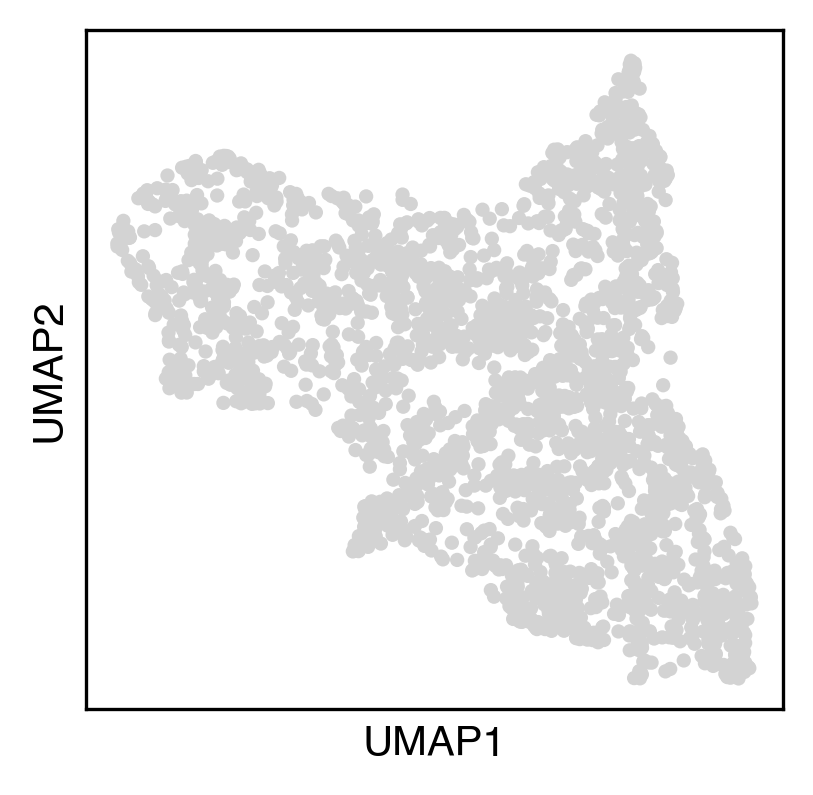

In [7]:
# Load spatial information
# [Note]:
# For simulated data without spatial coordinates, we replace them with the umap location:
umap_df = utils.get_umap(adata, display=True)
map_info = utils.get_simu_map_info(umap_df)

# Create dummy dict. as img_metadata
img_metadata = {
    'img': None,
    'map_info': map_info,
    'scalefactor': None
}

### (2). Preprocessing (finding anchor spots)
- Identify anchor spot locations
For simulated data without spatial coordinates, we replace them the umap location:

Instantiate parameters for Starfysh model training:
- Raw & normalized counts after taking highly variable genes
- filtered signature genes
- library size & spatial smoothed library size (log-transformed)
- Anchor spot indices (`anchors_df`) for each cell type & their signature means (`sig_means`)

In [8]:
# Parameters for training
visium_args = utils.VisiumArguments(adata,
                                    adata_normed,
                                    gene_sig,
                                    img_metadata,
                                    n_anchors=60,
                                    window_size=3
                                   )

adata, adata_normed = visium_args.get_adata()

[2023-04-10 11:36:05] Subsetting highly variable & signature genes ...
[2023-04-10 11:36:05] Smoothing library size by taking averaging with neighbor spots...
[2023-04-10 11:36:06] Retrieving & normalizing signature gene expressions...
[2023-04-10 11:36:06] Identifying anchor spots (highly expression of specific cell-type signatures)...


- Visualize the spatial data

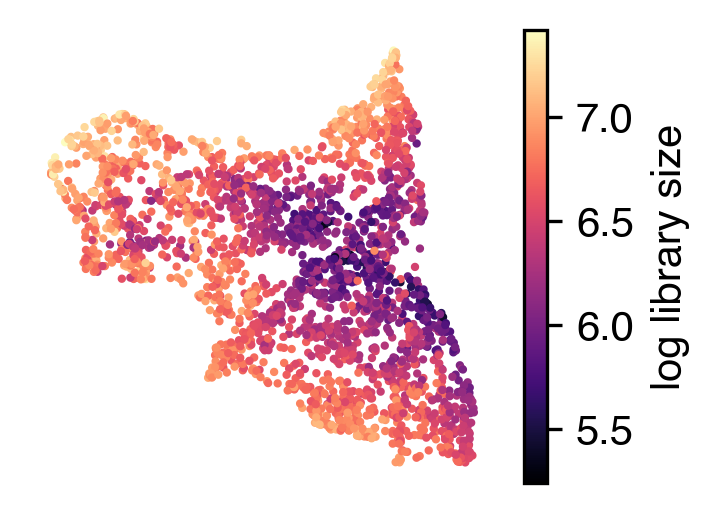

In [9]:
plot_utils.plot_spatial_feature(adata,
                                map_info,
                                visium_args.log_lib,
                                label='log library size'
                               )

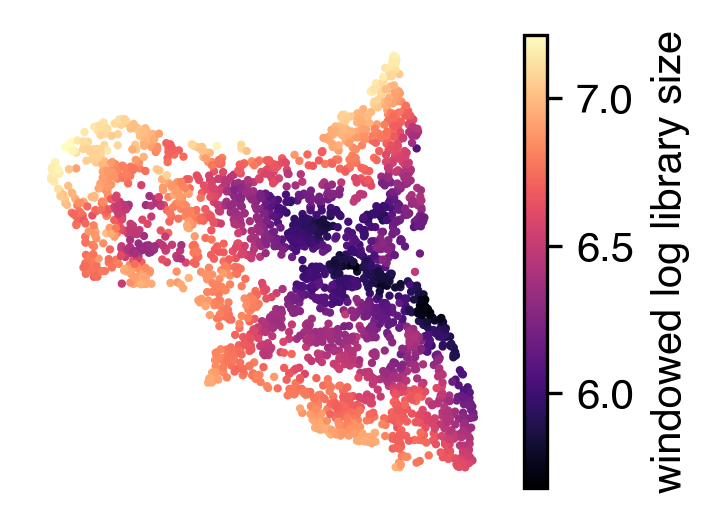

In [10]:
plot_utils.plot_spatial_feature(adata,
                                map_info,
                                visium_args.win_loglib,
                                label='windowed log library size',
                                )

plot raw gene expression:

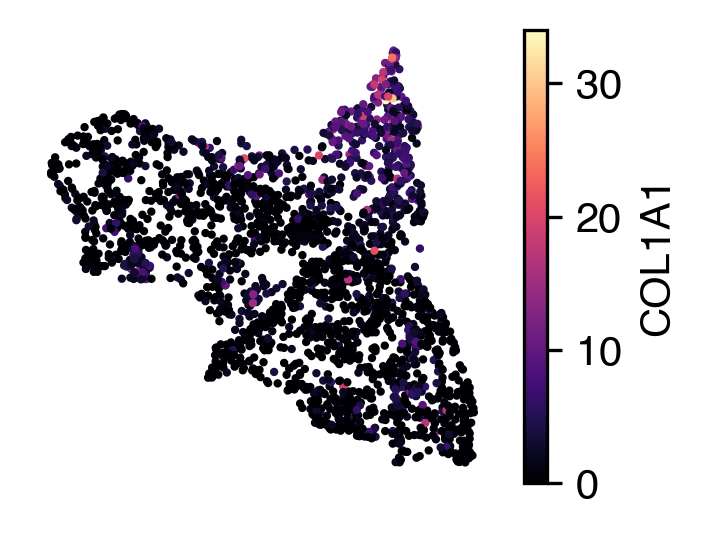

In [11]:
plot_utils.plot_spatial_gene(adata,
                             map_info,
                             gene_name='COL1A1'
                            )

- Visuliaze anchor spots

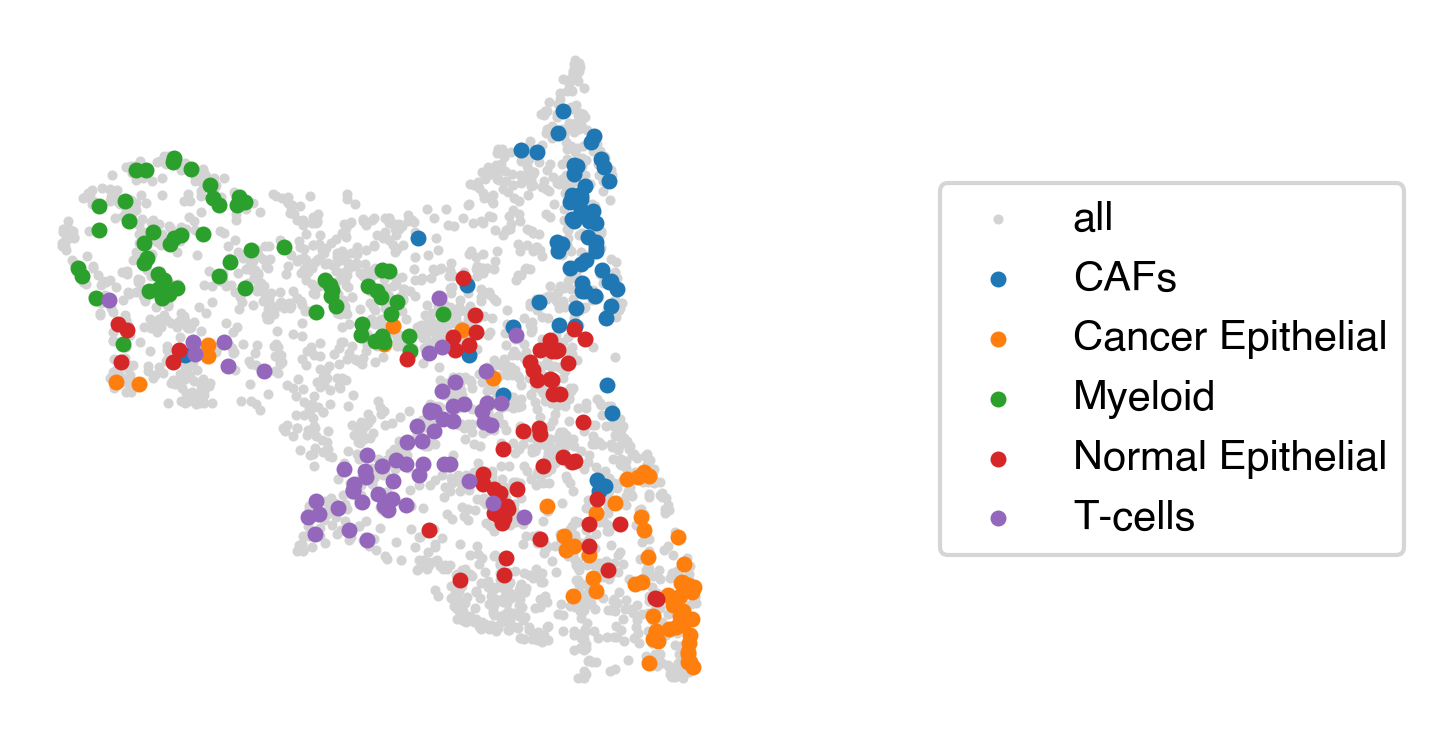

In [12]:
plot_utils.plot_anchor_spots(umap_df,
                             visium_args.pure_spots,
                             visium_args.sig_mean,
                             bbox_x=2
                            )

We observe that `Cancer` & `Normal` epithelial anchor spots are highly overlapped given input signatures.

### (3). Optional: Archetypal Analysis
Overview:
If users don't provide annotated gene signature sets with cell types, Starfysh identifies candidates for cell types via archetypal analysis (AA). The underlying assumption is that the geometric "extremes" are identified as the purest cell types, whereas all other spots are mixture of the "archetypes". If the users provide the gene signature sets, they can still optionally apply AA to refine marker genes and update anchor spots for known cell types. In addition, AA can identify & assign potential novel cell types / states. Here are the features provided by the optional archetypal analysis:
- Finding archetypal spots & assign 1-1 mapping to their closest anchor spot neighbors
- Finding archetypal marker genes & append them to marker genes of annotated cell types
- Assigning novel cell type / cell states as the most distant archetypes

Overall, Starfysh provides the archetypal analysis as a complementary toolkit for automatic cell-type annotation & signature gene completion:<br>

1. *If signature genes aren't provided:* <br><br>Archetypal analysis defines the geometric extrema of the data as major cell types with corresponding marker genes.<br><br>

2. *If full signature genes are known*: <br><br>Users can skip this section and use only the signature priors<br><br>

3. *If signature genes are incomplete or require refinement*: <br><br>Archetypal analysis can be applied to
    a. Refine signatures of certain cell types
    b. Find novel cell types / states that haven't been provided from the input signature


#### If signature genes aren't provided

Note: <br>
- Intrinsic Dimension (ID) estimator is implemented to estimate the lower-bound for the number of archetypes $k$, followed by elbow method with iterations to identify the optimal $k$. By default, a [conditional number](https://scikit-dimension.readthedocs.io/en/latest/skdim.id.FisherS.html) is set as 30; if you believe there are potentially more / fewer cell types, please increase / decrease `cn` accordingly.

Major cell types & corresponding markers are represented by the inferred archetypes:<br><br>



```Python
aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes(r=40)

# (1). Find archetypal spots & archetypal clusters
arche_df = aa_model.find_archetypal_spots(major=True)

# (2). Define "signature genes" as marker genes associated with each archetypal cluster
gene_sig = aa_model.find_markers(n_markers=30, display=False)
gene_sig.head()
```

#### If full signature genes are known

Users can skip this section & run Starfysh

#### If signature genes are provided with potential incomplete annotations

**In this tutorial, we show an example to re-define anchors & signatures with archetypal analysis**:<br>
In the annotated gene signatures provided by Wu et al., we found that the marker from
normal and cancer epithelials highly overlaps, thus creating confusions to separate those cell types.
Here we re-define markers and update new anchor spots for `Cancer Epithelials` from the
*most distant archetype* unmapped to any cell-type specific anchor spots:

In [13]:
aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes(cn=10, converge=1e-2, display=False)
# (1). Find archetypal spots & archetypal clusters
arche_df = aa_model.find_archetypal_spots(major=True)

# (2). Find marker genes associated with each archetypal cluster
markers_df = aa_model.find_markers(n_markers=30, display=False)

# (3). Map archetypes to closest anchors (1-1 per cell type)
anchors_df = visium_args.get_anchors()
map_df, map_dict = aa_model.assign_archetypes(anchors_df)

# (4). Optional: Find the most distant archetypes that are not assigned to any annotated cell types
distant_arches = aa_model.find_distant_archetypes(anchors_df, n=3)

[2023-04-10 11:36:09] Computing intrinsic dimension to estimate k...


4 components are retained using conditional_number=10.00


[2023-04-10 11:36:10] Estimating lower bound of # archetype as 3...
[2023-04-10 11:36:16] Calculating UMAPs for counts + Archetypes...
[2023-04-10 11:36:26] Calculating UMAPs for counts + Archetypes...
[2023-04-10 11:36:33] 0.7838 variance explained by raw archetypes.
Merging raw archetypes within 20 NNs to get major archetypes
[2023-04-10 11:36:33] Finding 20 nearest neighbors for each archetype...
[2023-04-10 11:36:34] Finding 30 top marker genes for each archetype...


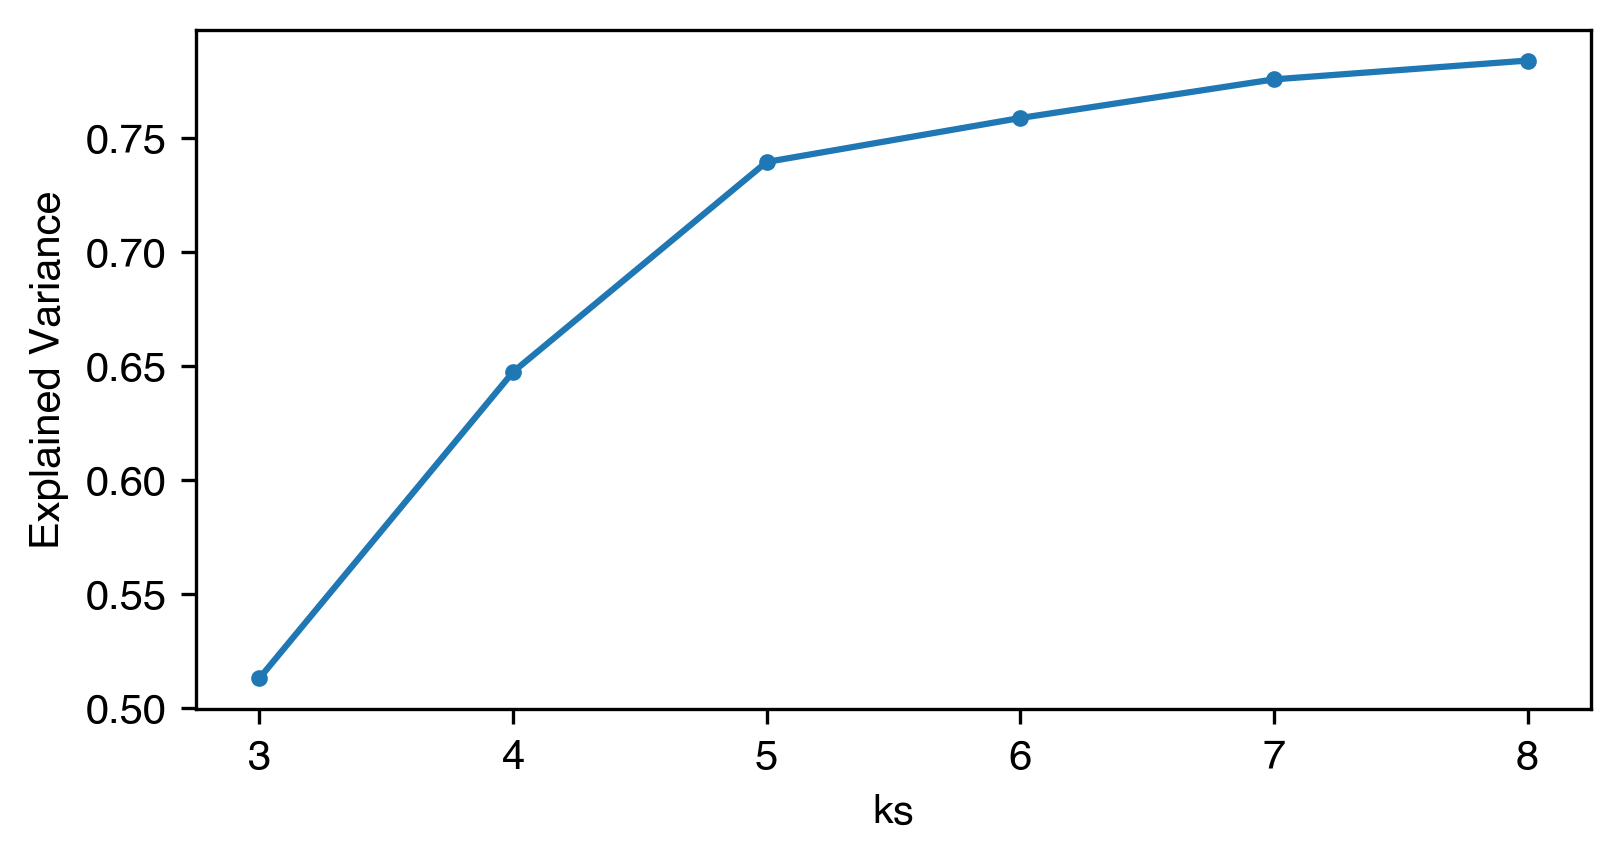

In [14]:
plot_utils.plot_evs(evs, kmin=aa_model.kmin)

- Visualize archetypes

(<Figure size 1800x1200 with 1 Axes>, <AxesSubplot:>)

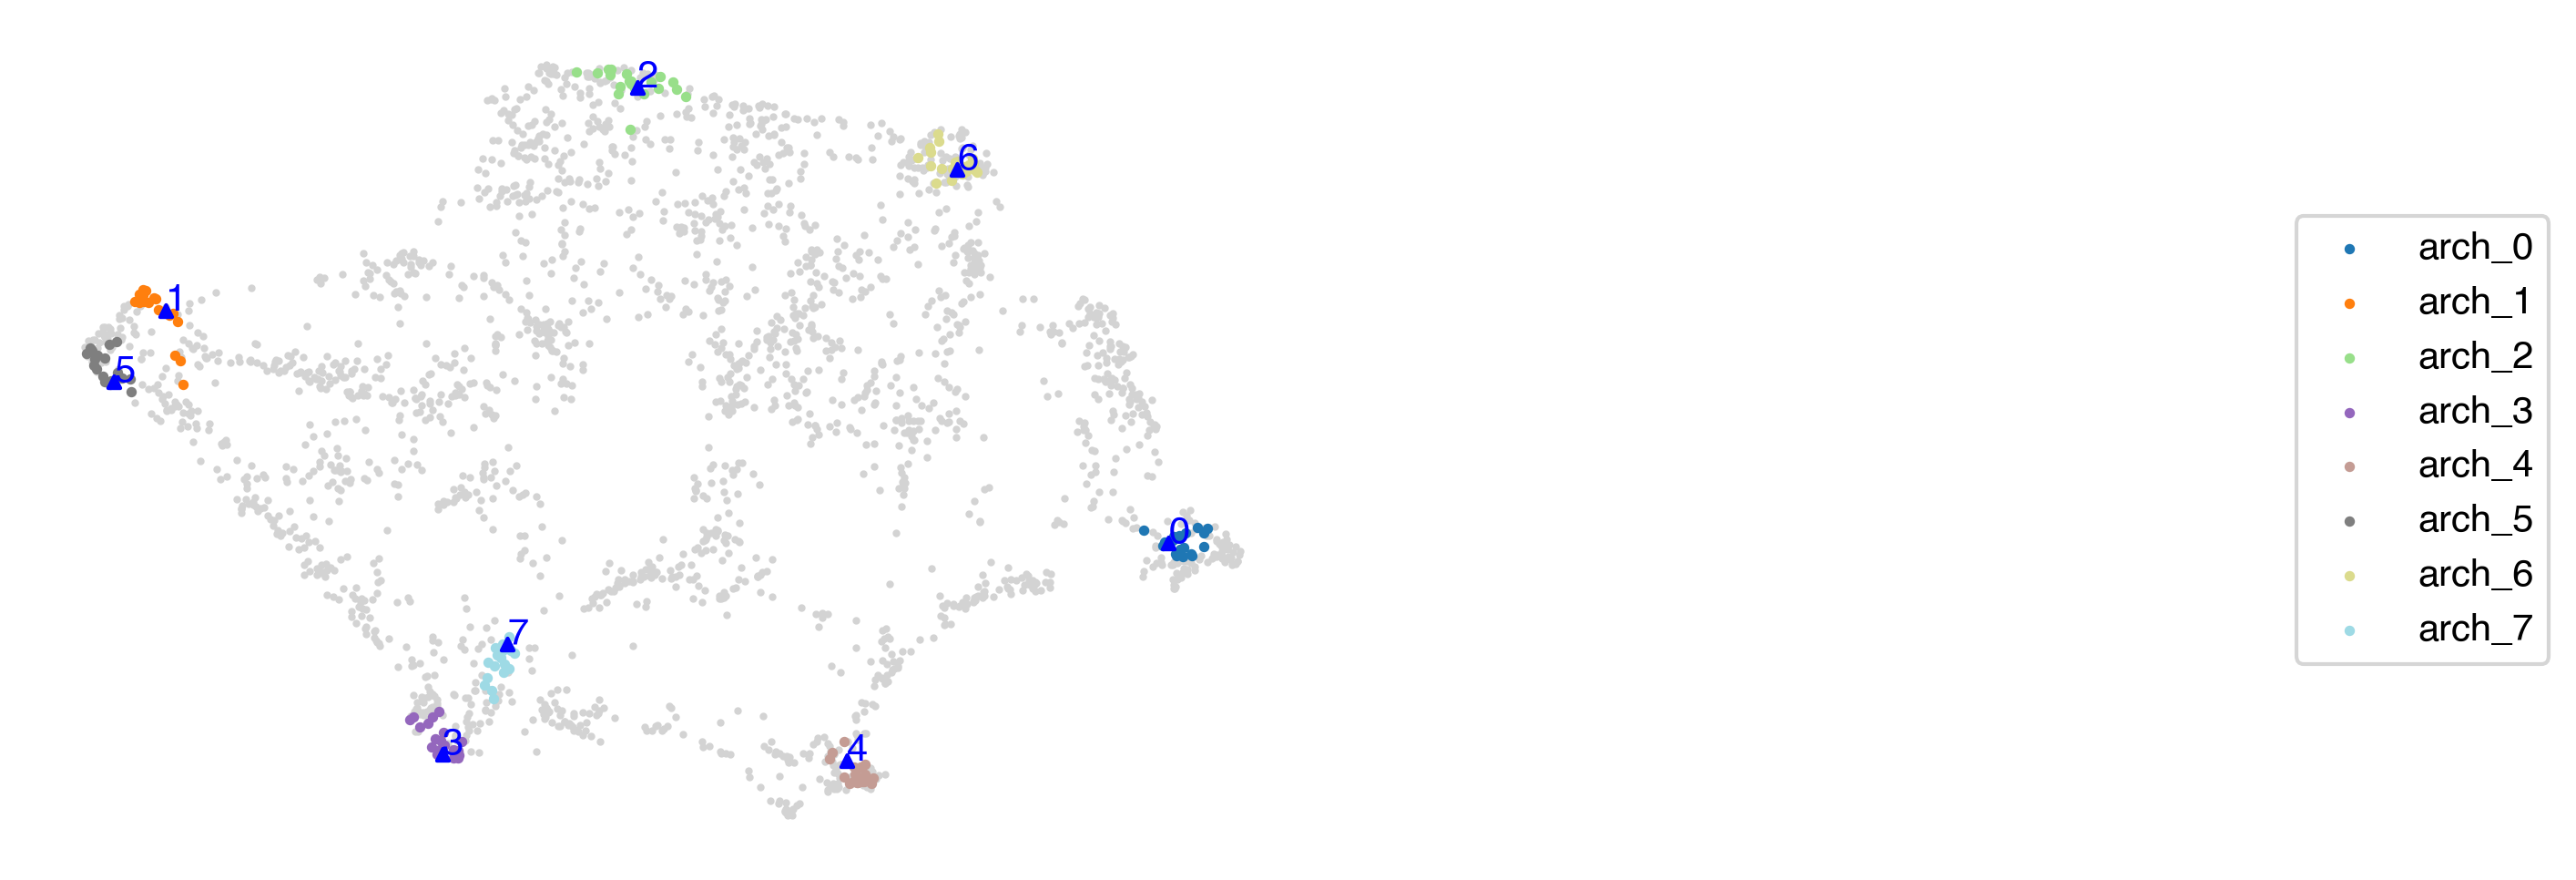

In [17]:
aa_model.plot_archetypes(do_3d=False, major=True, disp_cluster=True)

In [19]:
from scipy.stats import pearsonr, gaussian_kde

def plot_type_all(
                  u, 
                  proportions, 
                  inference_outputs=None,
                  qc_= True
                 ):
    if qc_:
        qc_m = inference_outputs["qc_m"].detach().cpu().numpy()
        group_c = np.argmax(qc_m,axis=1)
    else:
        group_c = np.argmax(np.array(proportions),axis=1)
    plt.figure(dpi=500,figsize=(6,4))
    #cmaps = ['Blues','Greens','Reds','Oranges','Purples',
    #         'Greys','YlGn','BuGn','BuPu','cool'
    #        ]
    cmaps = ['Blues','Greens','Reds','Oranges','Purples',
             'Blues','Blues','Blues','Blues','Blues'
            ]
    for i in range(proportions.shape[1]):
        if qc_:
            plt.scatter(u[group_c==i,0],u[group_c==i,1],s=5,c = qc_m[group_c==i,i], cmap=cmaps[i])
        else:
            plt.scatter(u[group_c==i,0],u[group_c==i,1],s=5,c = np.array(proportions)[group_c==i,i], cmap=cmaps[i])
    plt.legend(proportions.columns,loc='right', bbox_to_anchor=(1.6,0.5),)
    plt.axis('off')

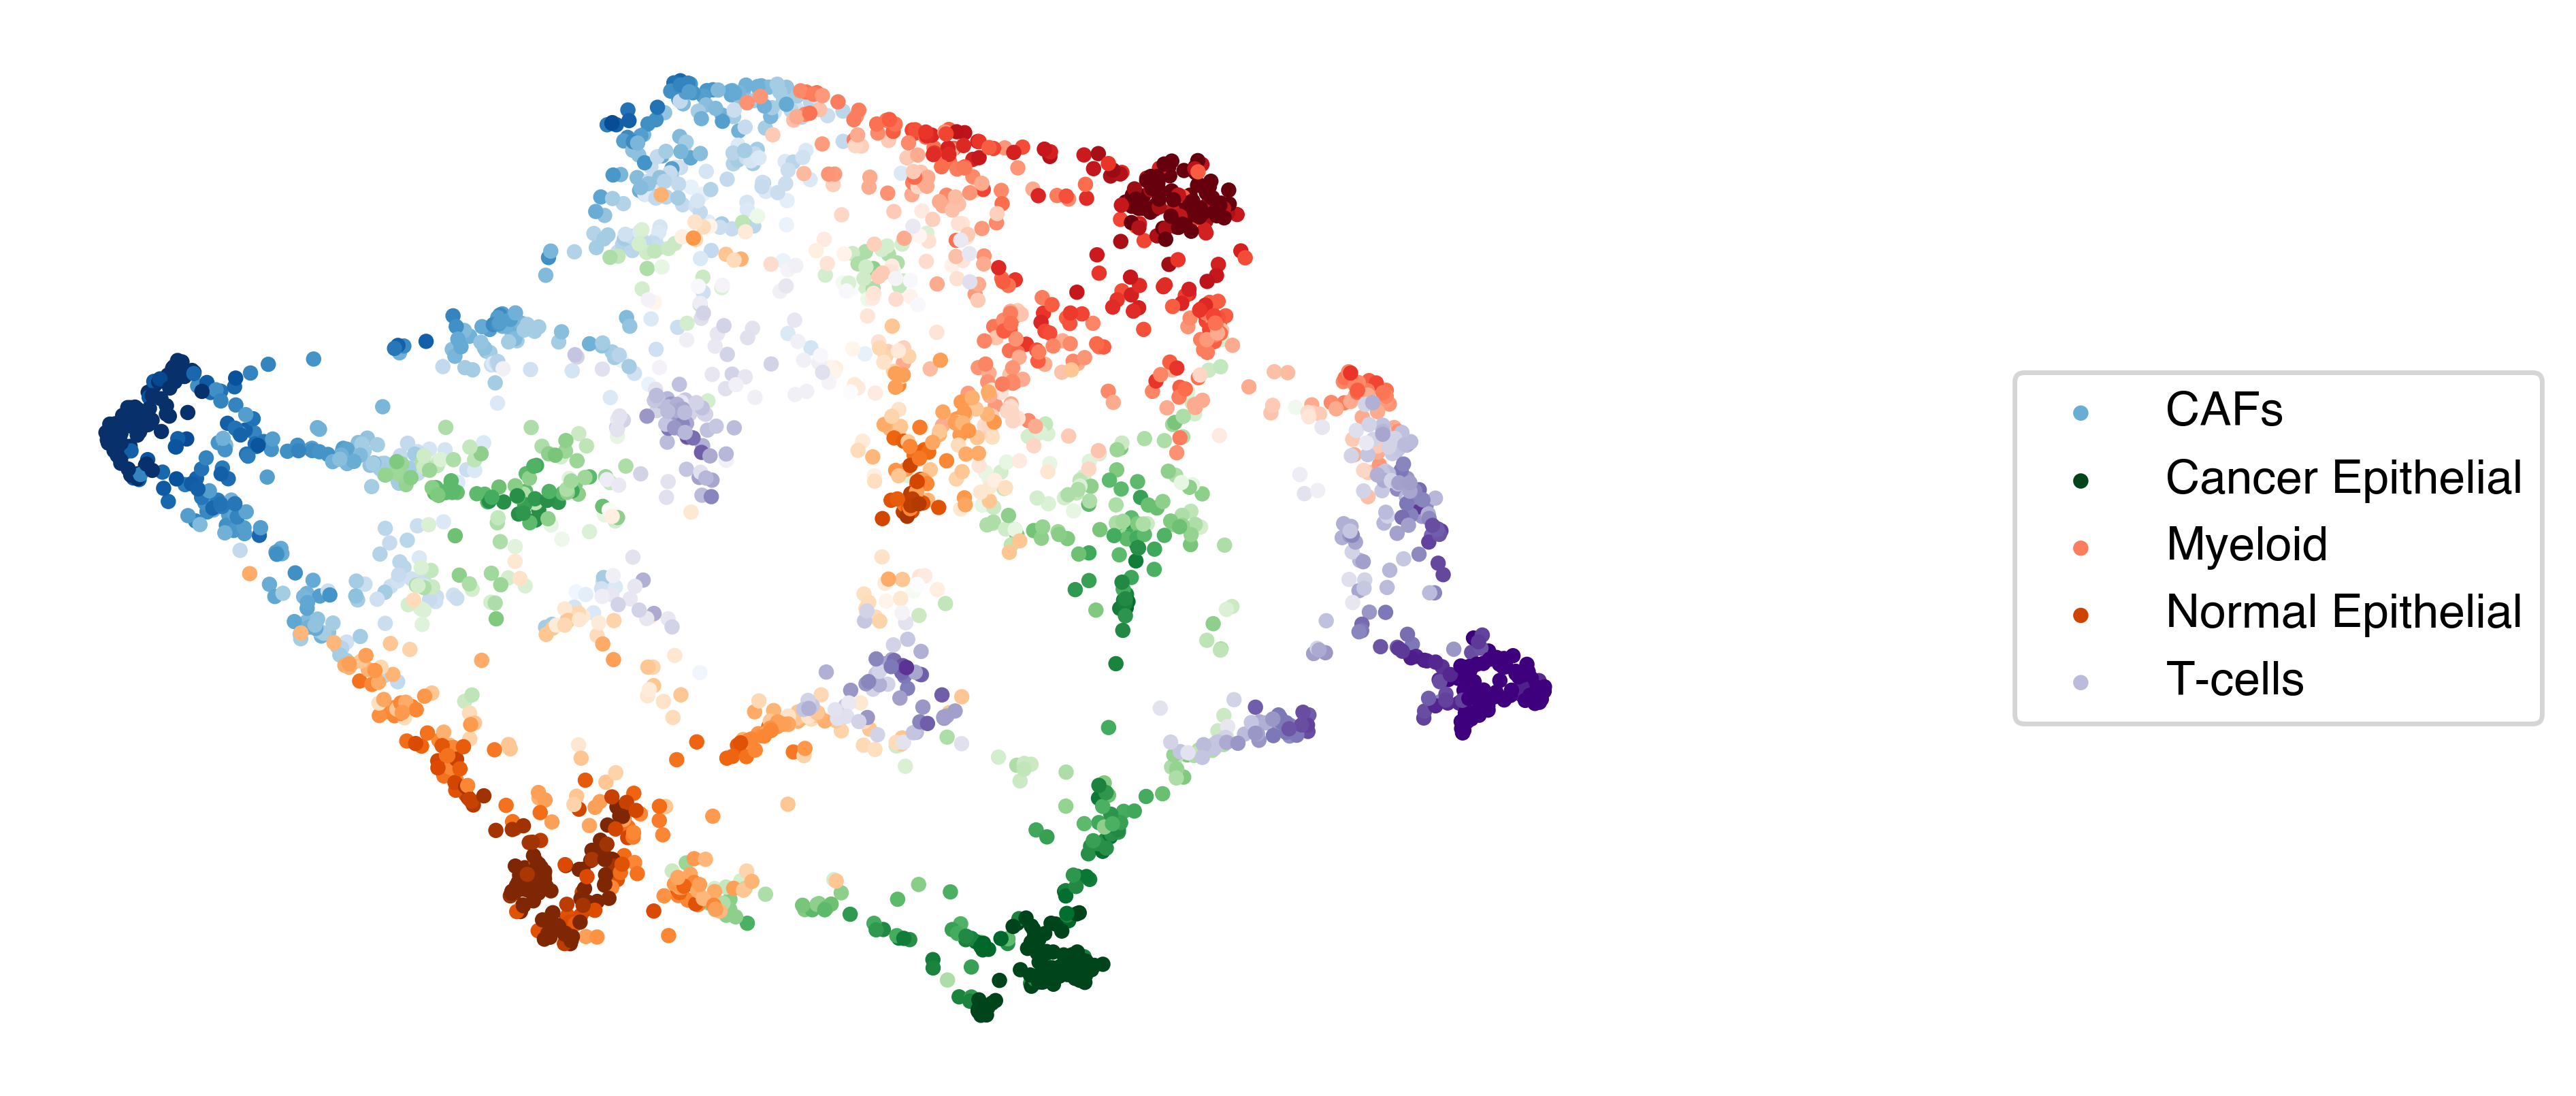

In [22]:
plot_type_all(
              aa_model.U[:umap_df.shape[0],:],
              proportions,
              qc_=False
             )

- Visualize overlapping ratio between archetypal & anchor spots:

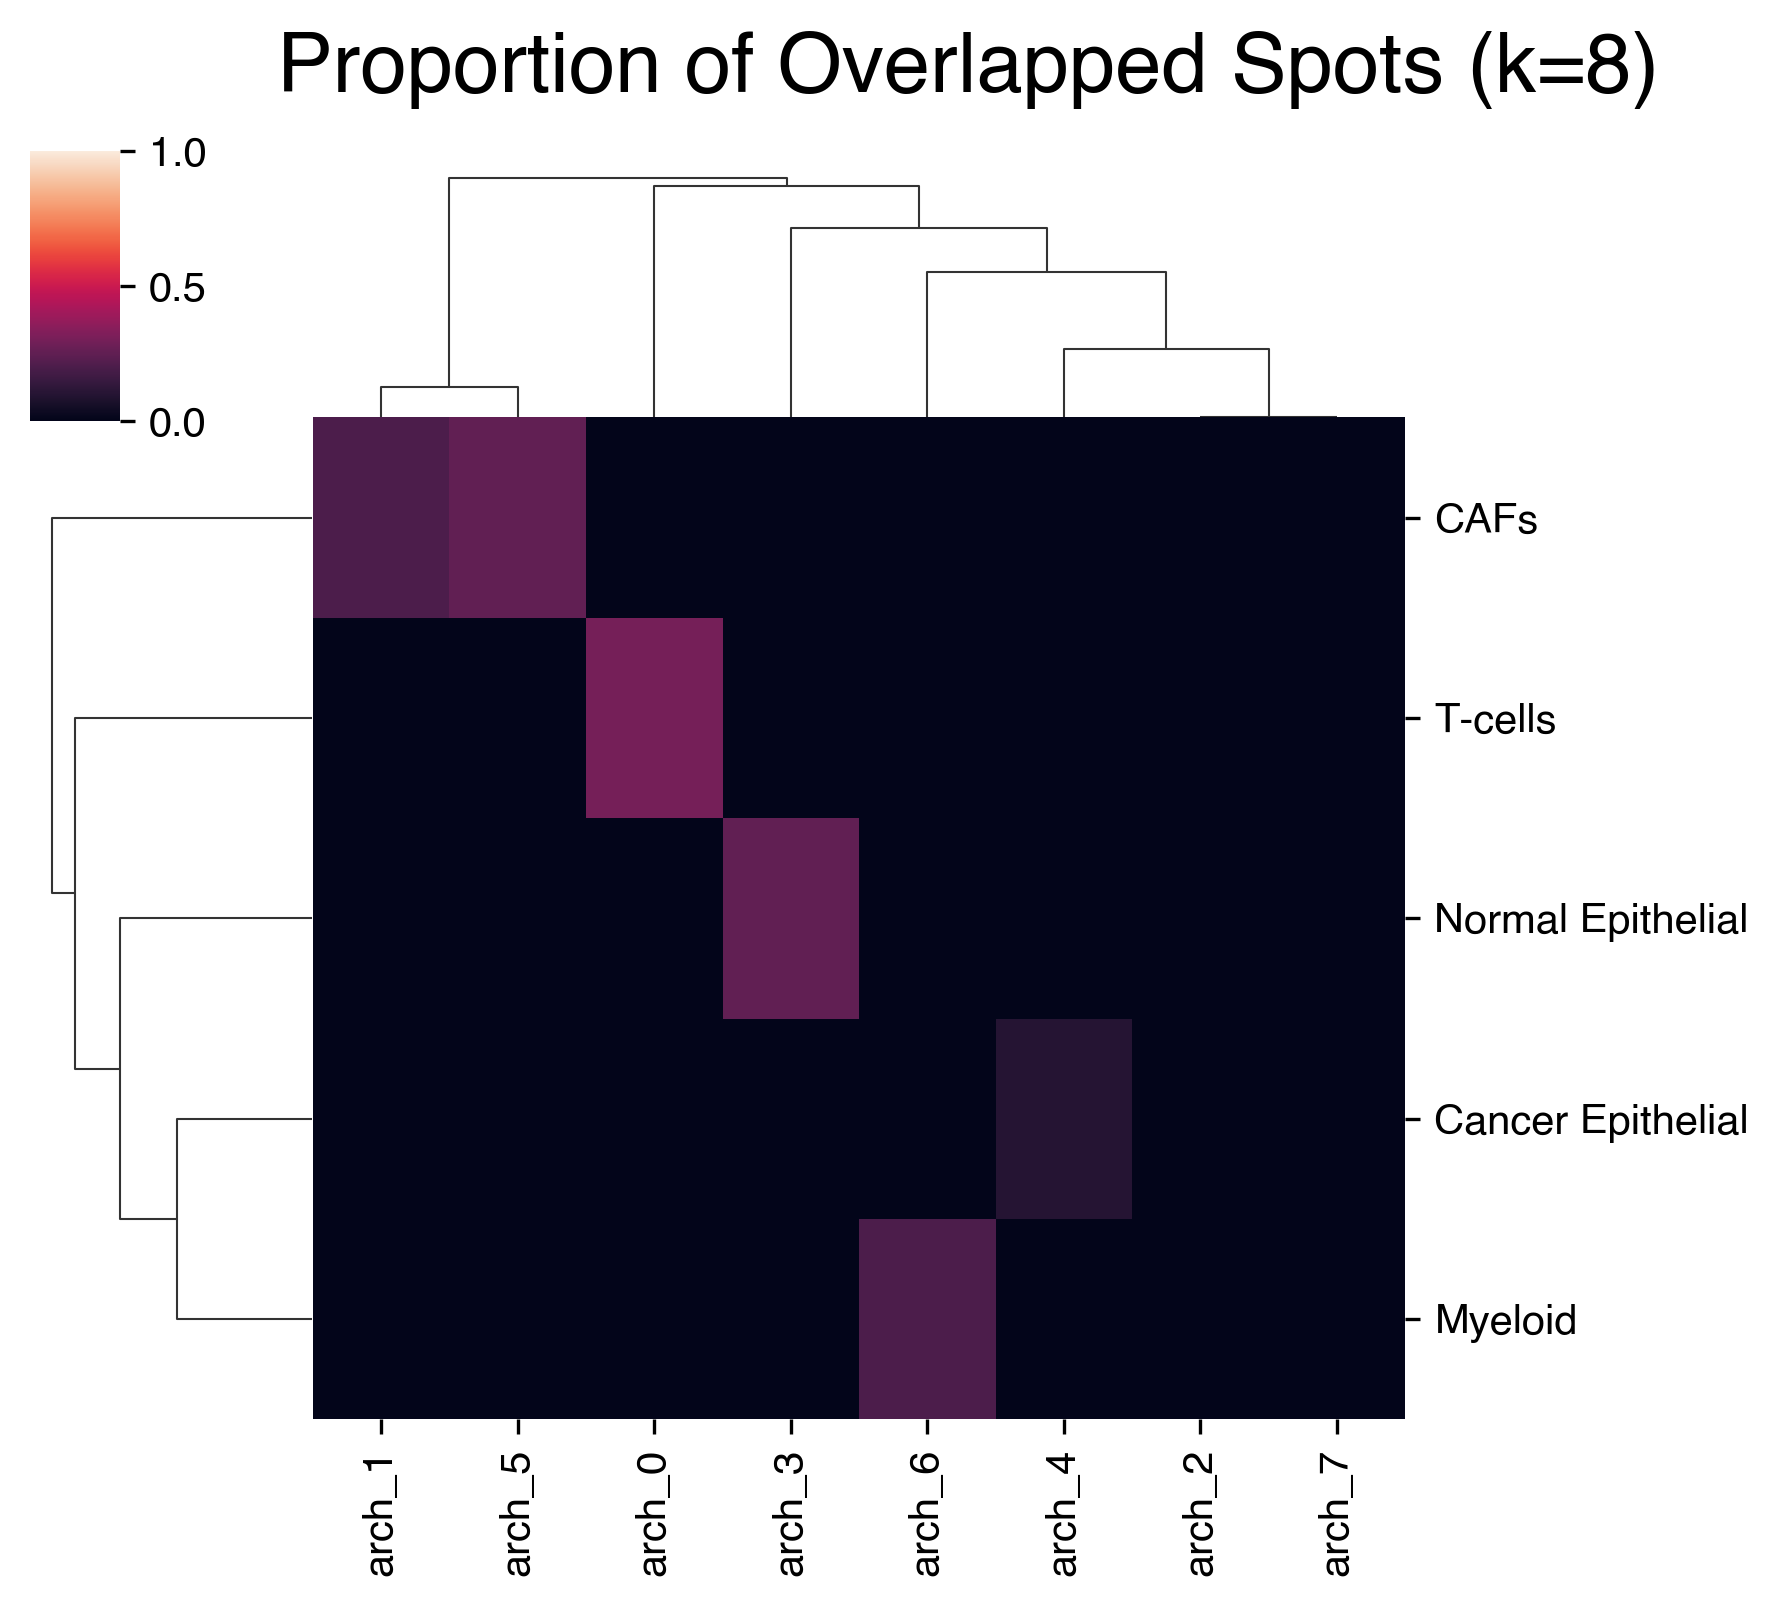

In [14]:
aa_model.plot_mapping(map_df)

- Re-calculate anchor spots by replacing `Cnacer Epithelial` signautures with the most distant archetype:

In [18]:
distant_arches[0]

'arch_2'

[2023-04-10 11:17:52] Recalculating anchor spots (highly expression of specific cell-type signatures)...


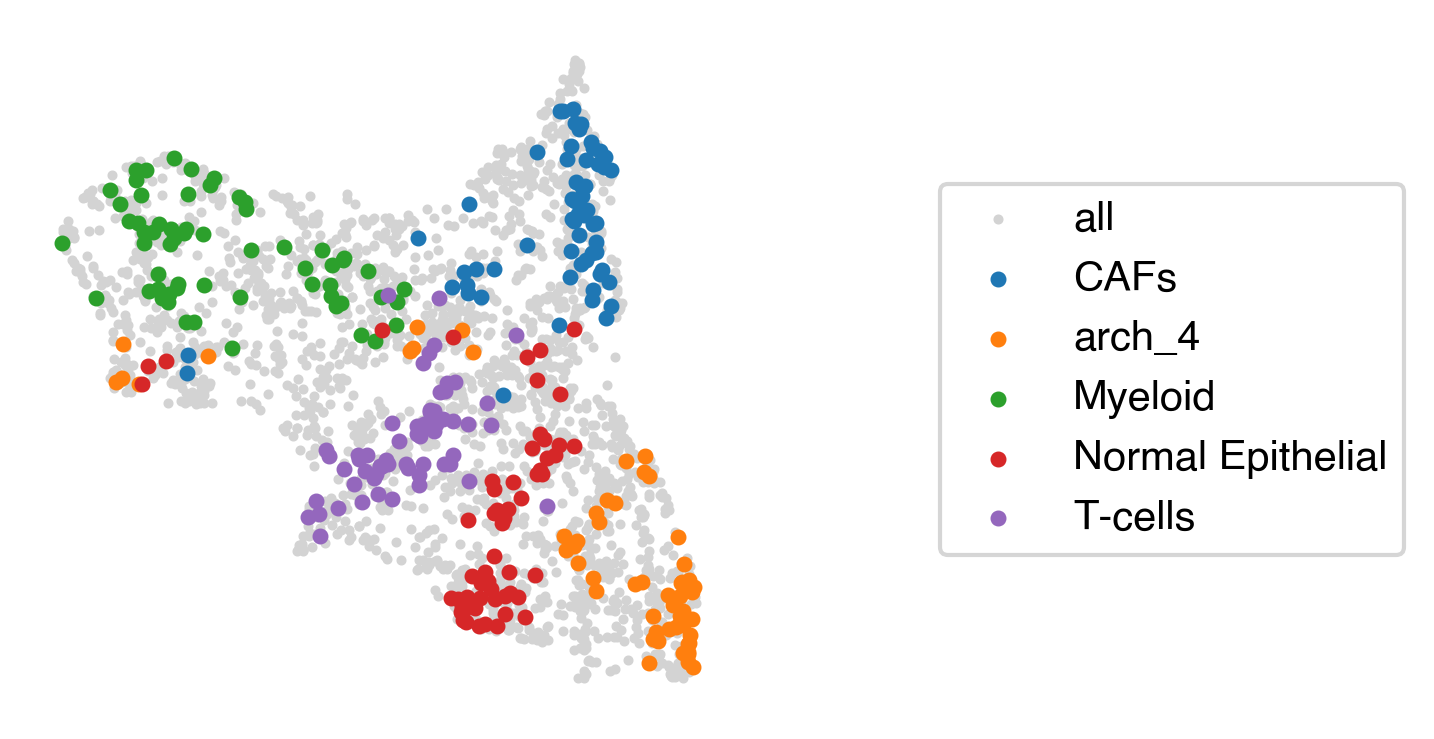

In [23]:
arche_to_repl = 'arch_4'
visium_args.replace_factors(
    factors_to_repl='Cancer Epithelial',
    arche_markers=markers_df[arche_to_repl]
)

# Get updated adata & signatures
adata, adata_normed = visium_args.get_adata()
gene_sig = visium_args.gene_sig
cell_types = gene_sig.columns

plot_utils.plot_anchor_spots(umap_df,
                             visium_args.pure_spots,
                             visium_args.sig_mean,
                             bbox_x=2
                            )


[2023-03-10 16:34:06] Recalculating anchor spots (highly expression of specific cell-type signatures)...


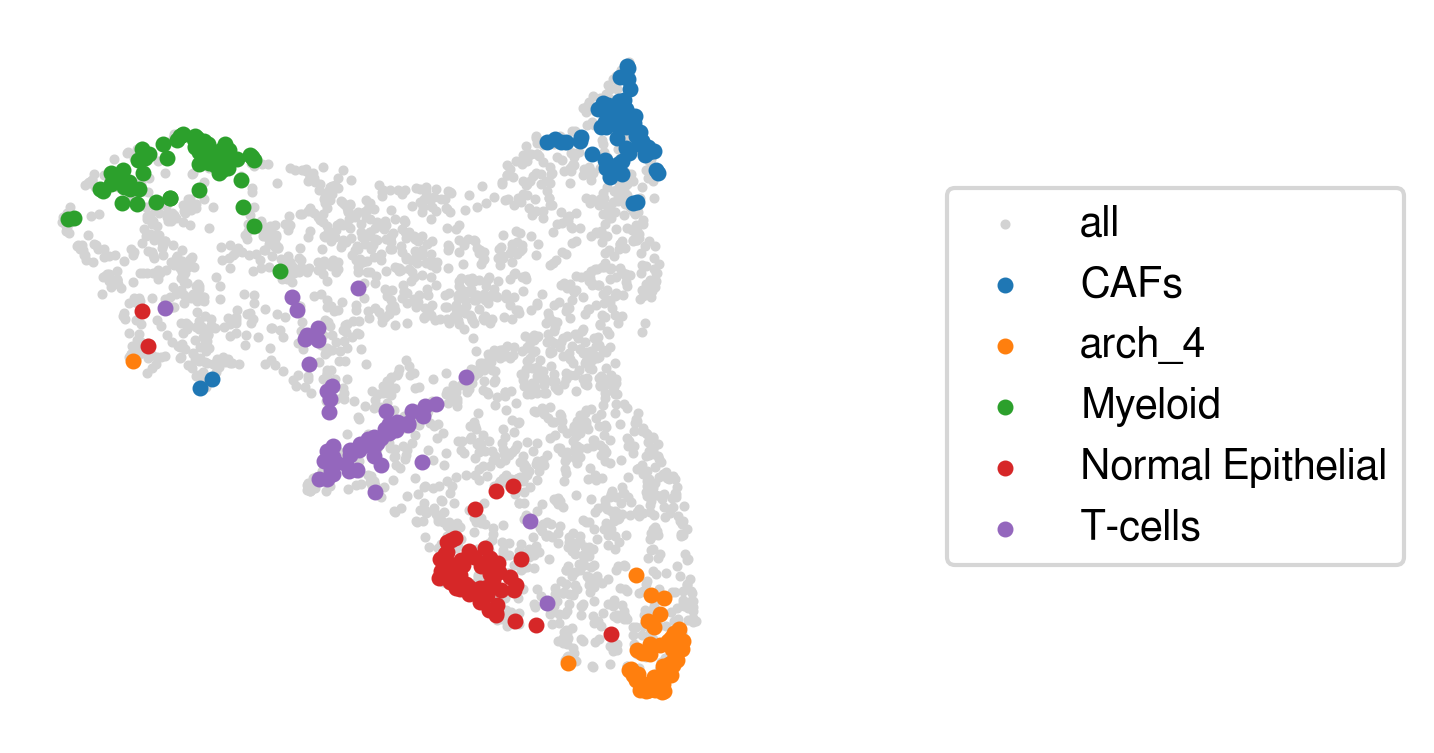

In [17]:
arche_to_repl = distant_arches[0]
visium_args.replace_factors(
    factors_to_repl='Cancer Epithelial',
    arche_markers=markers_df[arche_to_repl]
)

# Get updated adata & signatures
adata, adata_normed = visium_args.get_adata()
gene_sig = visium_args.gene_sig
cell_types = gene_sig.columns

plot_utils.plot_anchor_spots(umap_df,
                             visium_args.pure_spots,
                             visium_args.sig_mean,
                             bbox_x=2
                            )



**[Note]**:
Compared with the previous visualization, it is observed that after replacing signatures of `Cancer Epithelial` with `arch_4`,  `Cancer` & `Normal` epithelial anchors are now separable.

##  Run starfysh

We perform `n_repeat` random restarts and select the best model with lowest loss for parameter `c` (inferred cell-type proportions):

### (1). Model parameters

In [17]:
n_repeats = 1
epochs = 200
#patience = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### (2). Model training

In [18]:
# Run models
model, loss = utils.run_starfysh(visium_args,
                                 n_repeats=n_repeats,
                                 epochs=epochs,
                                 #patience=patience,
                                 poe=False,
                                 device=device
                                )

[2023-04-10 11:38:24] Running Starfysh with 1 restarts, choose the model with best parameters...
[2023-04-10 11:38:24]  ===  Restart Starfysh 1 === 

[2023-04-10 11:38:24] Initializing model parameters...
[2023-04-10 11:38:55] Epoch[10/200], train_loss: 614.5321, train_reconst: 516.2123, train_u: 5.4608,train_z: 19.1563,train_c: 76.9469,train_n: 2.2166
[2023-04-10 11:39:27] Epoch[20/200], train_loss: 571.3374, train_reconst: 490.1691, train_u: 5.8656,train_z: 18.1765,train_c: 60.6102,train_n: 2.3815
[2023-04-10 11:39:56] Epoch[30/200], train_loss: 557.1576, train_reconst: 475.9993, train_u: 6.7065,train_z: 17.8004,train_c: 61.0023,train_n: 2.3556
[2023-04-10 11:40:27] Epoch[40/200], train_loss: 539.5770, train_reconst: 466.6797, train_u: 7.7636,train_z: 17.3815,train_c: 53.0873,train_n: 2.4285
[2023-04-10 11:40:58] Epoch[50/200], train_loss: 527.2632, train_reconst: 456.3421, train_u: 8.9215,train_z: 17.4044,train_c: 51.0991,train_n: 2.4176
[2023-04-10 11:41:30] Epoch[60/200], train_lo

### (3). Downstream analysis

#### Parse Starfysh inference output

In [19]:
inference_outputs, generative_outputs = sf_model.model_eval(model,
                                                            adata,
                                                            visium_args,
                                                            poe=False,
                                                            device=device)

####  Visualize starfysh deconvolution results

##### Gene sig mean vs. inferred prop

In [20]:
for idx in range(len(cell_types)):
    post_analysis.gene_mean_vs_inferred_prop(inference_outputs,
                                             visium_args,
                                             idx=idx ## the order of the cell types
                                            )


NameError: name 'cell_types' is not defined

##### Compare the deconvolution against the ground-truth proportions

Load simulation ground-truths:

In [21]:
member = pd.read_csv(os.path.join('../data','simulated_ST_data_1','members.st_synth.csv'),index_col=0)
proportions = pd.read_csv(os.path.join('../data','simulated_ST_data_1','proportions.st_synth.csv'),index_col=0)

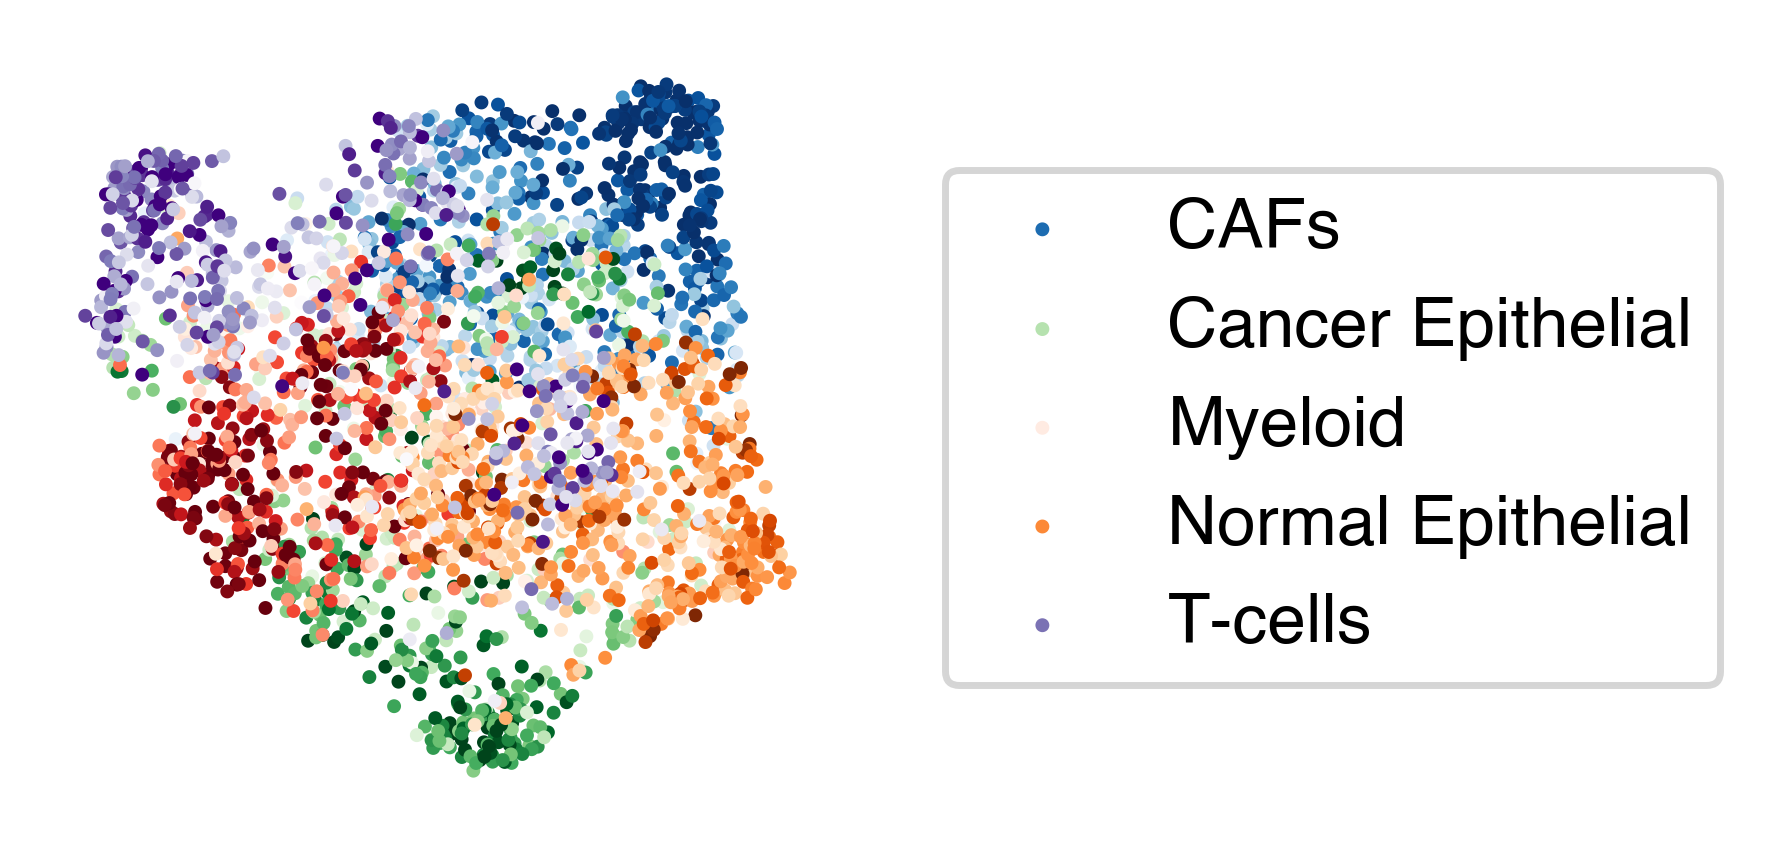

In [22]:
# Plot the ground-truth proportions on the inferred Z-space
qz_u = post_analysis.get_z_umap(adata.obsm['qz_m'])
post_analysis.plot_type_all(inference_outputs, qz_u, proportions)

In [28]:
dir(visium_args)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_sig_mean',
 '_norm_sig',
 '_update_anchors',
 '_update_img_patches',
 '_update_spatial_info',
 '_znorm_sig',
 'adata',
 'adata_norm',
 'append_factors',
 'gene_sig',
 'get_adata',
 'get_anchors',
 'get_img_patches',
 'img',
 'img_patches',
 'log_lib',
 'map_info',
 'params',
 'pure_dict',
 'pure_idx',
 'pure_spots',
 'replace_factors',
 'scalefactor',
 'sig_mean',
 'sig_mean_znorm',
 'win_loglib']

In [29]:
visium_args.sig_mean_znorm

CAFs  Cancer Epithelial   Myeloid  Normal Epithelial   T-cells
Spotx1     0.000000           0.000000  0.144415           0.000000  0.855585
Spotx2     0.000000           0.000000  0.230166           0.393423  0.376411
Spotx3     0.000000           0.689813  0.000000           0.310187  0.000000
Spotx4     0.000000           0.000000  0.000000           0.000000  1.000000
Spotx5     0.000000           0.000000  0.379451           0.000000  0.620549
...             ...                ...       ...                ...       ...
Spotx2547  0.934846           0.000000  0.000000           0.065154  0.000000
Spotx2548  0.000000           0.000000  1.000000           0.000000  0.000000
Spotx2549  0.000000           0.331802  0.661741           0.006457  0.000000
Spotx2550  0.699032           0.000000  0.118049           0.182920  0.000000
Spotx2551  0.000000           0.422724  0.000000           0.577276  0.000000

[2551 rows x 5 columns]

In [39]:
from scipy.stats import pearsonr, gaussian_kde
import seaborn as sns
def get_corr_map(df_1,  proportions):
    #qc_m_n = inference_outputs["qc_m"].detach().cpu().numpy()
    qc_m_n = df_1  
    corr_map_qcm = np.zeros([qc_m_n.shape[1],qc_m_n.shape[1]])

    for i in range(corr_map_qcm.shape[0]):
        for j in range(corr_map_qcm.shape[0]):
            corr_map_qcm[i, j], _ = pearsonr(qc_m_n.iloc[:,i], proportions.iloc[:, j])
              

    plt.figure(dpi=300,figsize=(3.2,3.2))
    ax = sns.heatmap(corr_map_qcm.T, annot=True,
                     cmap='RdBu_r',vmax=1,vmin=-1,
                     cbar_kws={'label': 'Cell type proportion corr.'}
                    )
    plt.xticks(np.array(range(qc_m_n.shape[1]))+0.5,labels=proportions.columns,rotation=90)
    plt.yticks(np.array(range(qc_m_n.shape[1]))+0.5,labels=proportions.columns,rotation=0)
    plt.xlabel('Estimated proportion')
    plt.ylabel('Ground truth proportion')

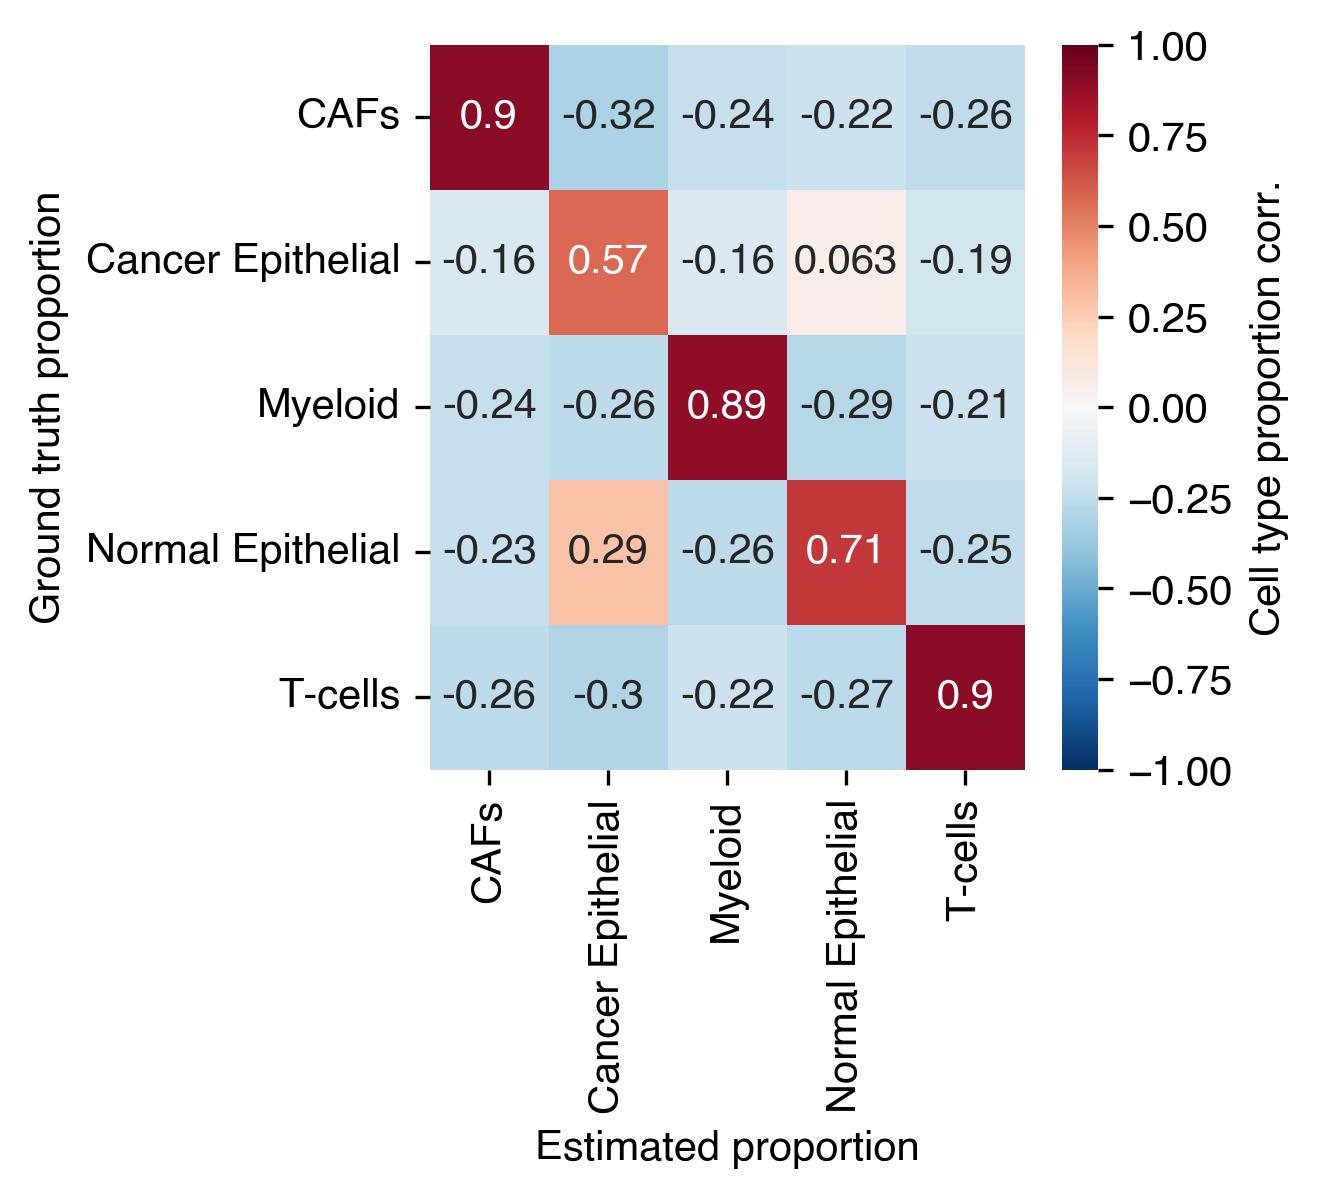

In [40]:
get_corr_map(visium_args.sig_mean_znorm,proportions)

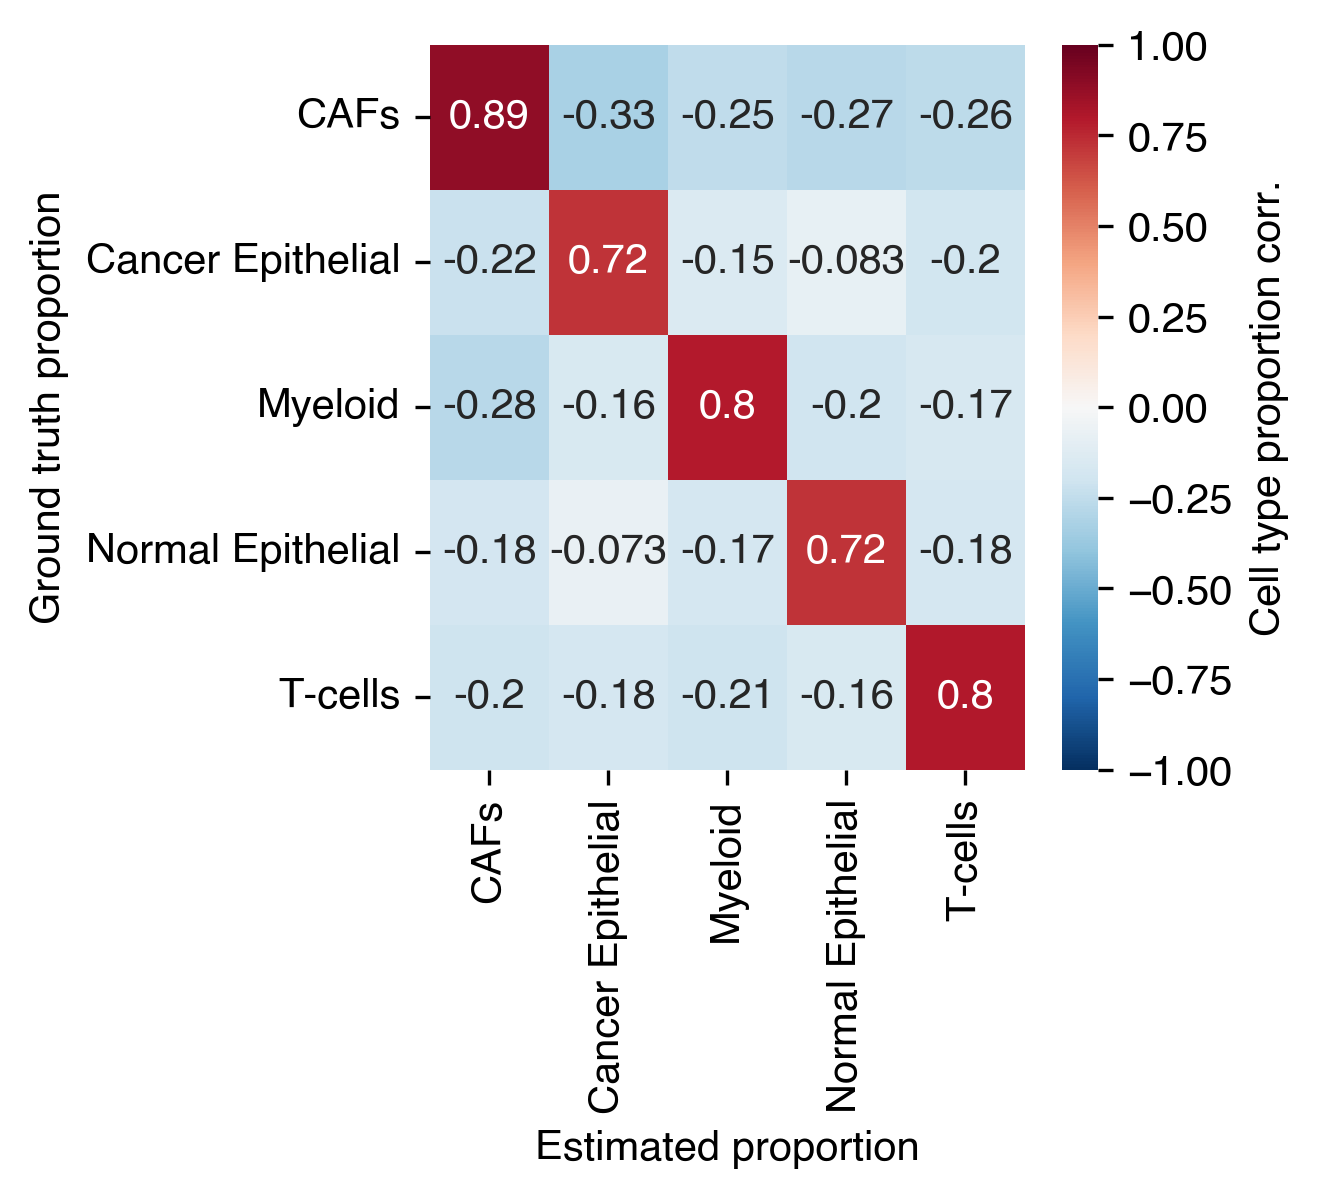

In [26]:
post_analysis.get_corr_map(inference_outputs,proportions)

In [41]:
from numpy import linalg as LA
def get_score_corrmap(inference_outputs,  proportions):
    qc_m_n = inference_outputs["qc_m"].detach().cpu().numpy()
    corr_map_qcm = np.zeros([qc_m_n.shape[1],qc_m_n.shape[1]])

    for i in range(corr_map_qcm.shape[0]):
        for j in range(corr_map_qcm.shape[0]):
            corr_map_qcm[i, j], _ = pearsonr(qc_m_n[:,i], proportions.iloc[:, j])
              
    a = corr_map_qcm.T-np.eye(qc_m_n.shape[1], dtype=int)
    return LA.norm(a)
score = get_score_corrmap(inference_outputs,proportions)
print(score)

1.0457597629812327


In [43]:
def get_score_corrmap(df_2,  proportions):
    qc_m_n = df_2 
    corr_map_qcm = np.zeros([qc_m_n.shape[1],qc_m_n.shape[1]])

    for i in range(corr_map_qcm.shape[0]):
        for j in range(corr_map_qcm.shape[0]):
            corr_map_qcm[i, j], _ = pearsonr(qc_m_n.iloc[:,i], proportions.iloc[:, j])
              
    a = corr_map_qcm.T-np.eye(qc_m_n.shape[1], dtype=int)
    return LA.norm(a)
score = get_score_corrmap(visium_args.sig_mean_znorm,proportions)
print(score)

1.2085390735460695


##### Spatial visualizations:

###### Inferred density

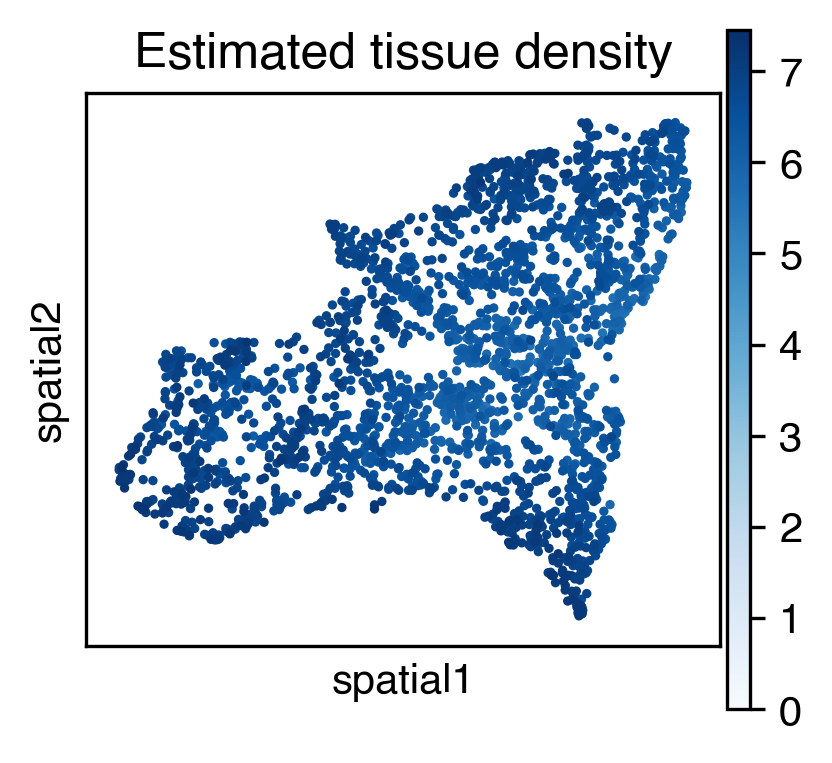

In [44]:
plot_utils.pl_spatial_inf_feature(adata,
                                  feature='ql_m',
                                  spot_size=0.2,
                                  cmap='Blues')

###### Inferred proportions

**Visualization on UMAP of data**

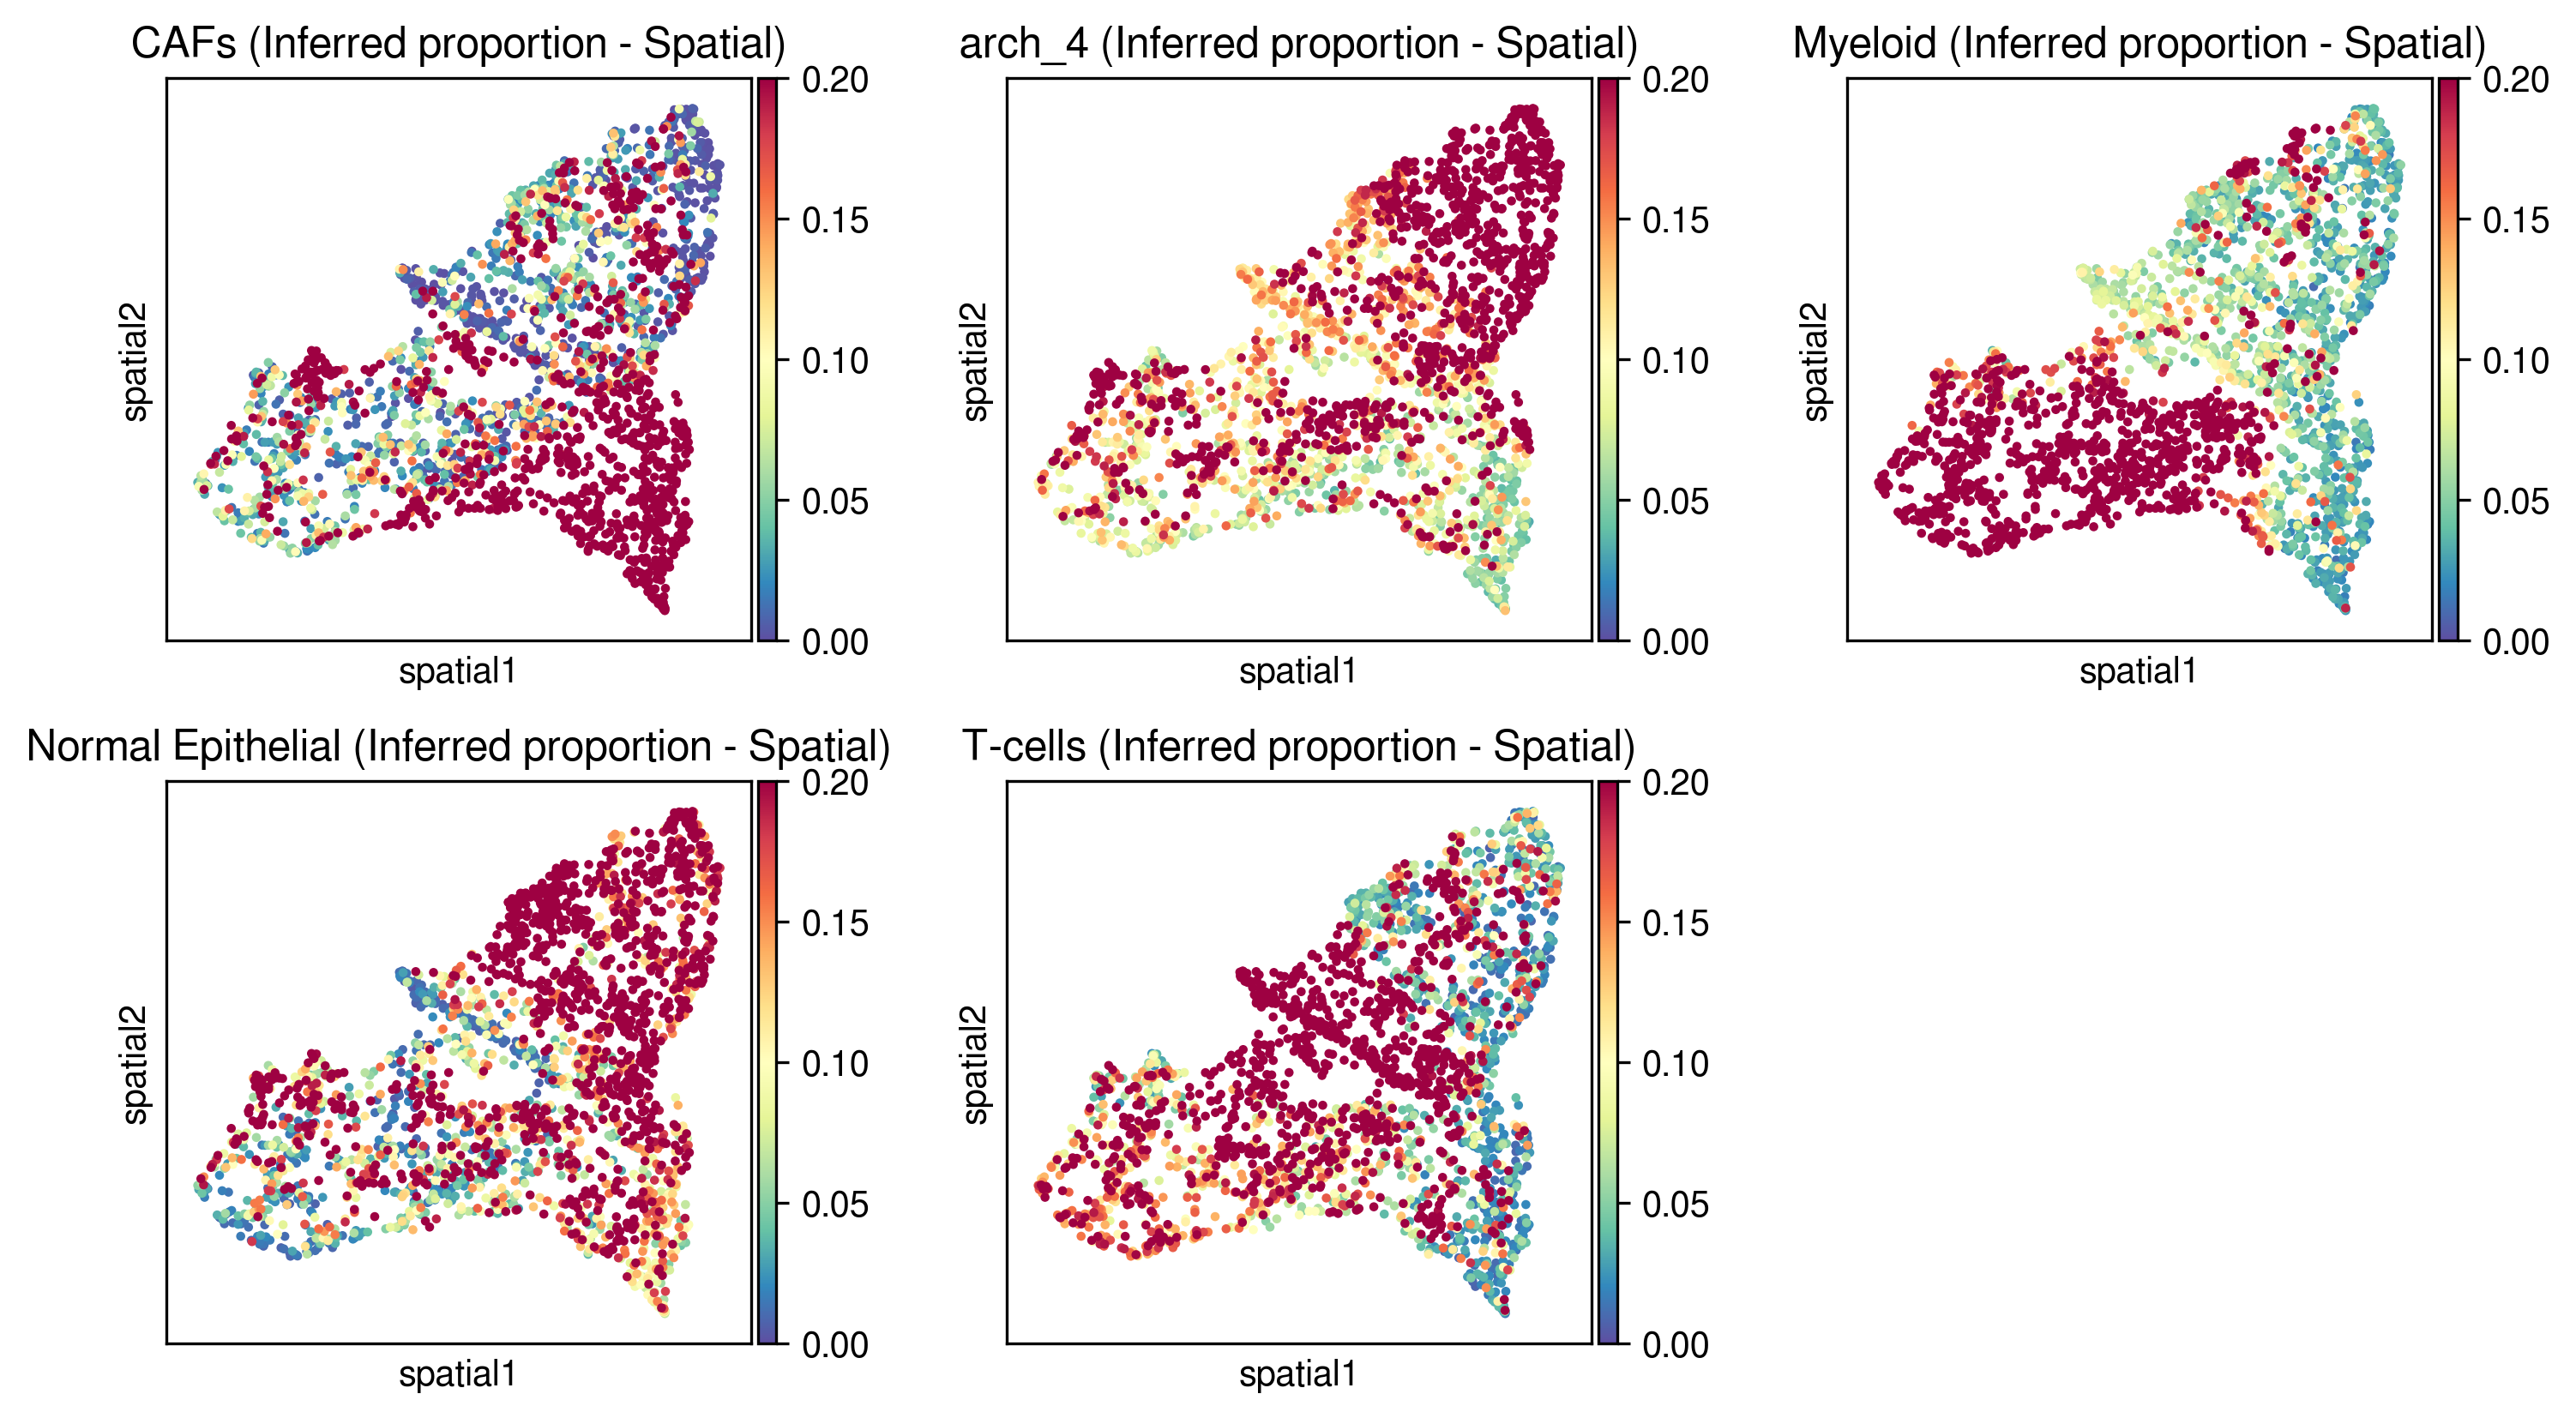

In [26]:
plot_utils.pl_spatial_inf_feature(adata,
                                  feature='qc_m',
                                  # To display for specific cell types:
                                  # factor = 'Cancer Epithelial', or factor = ['Cancer Epithelial, 'T-cells]
                                  spot_size=0.2,
                                  vmax=0.2)

**Visualization on UMAP of inferred `q(z)` space**

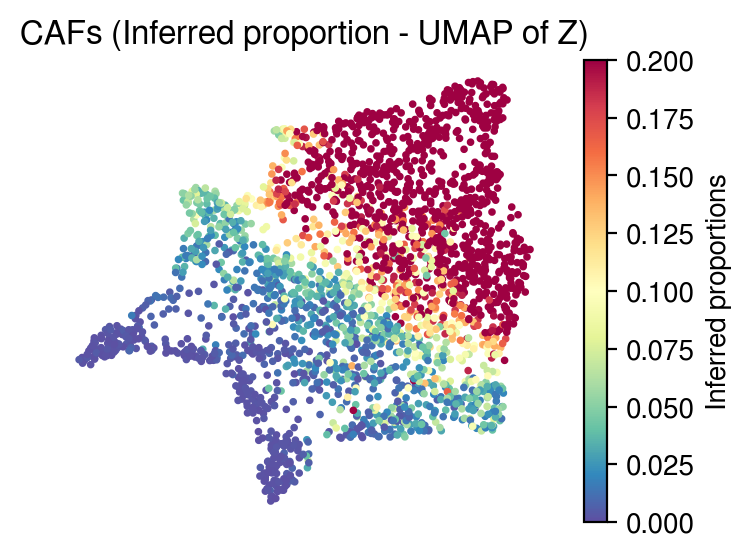

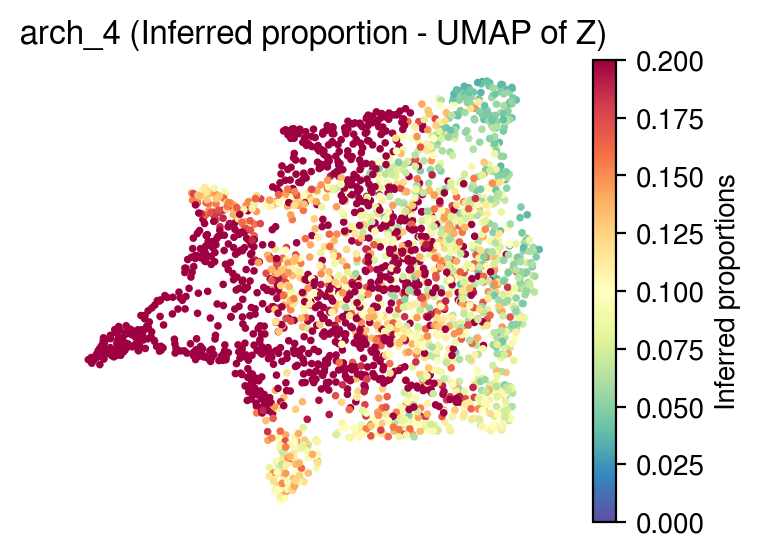

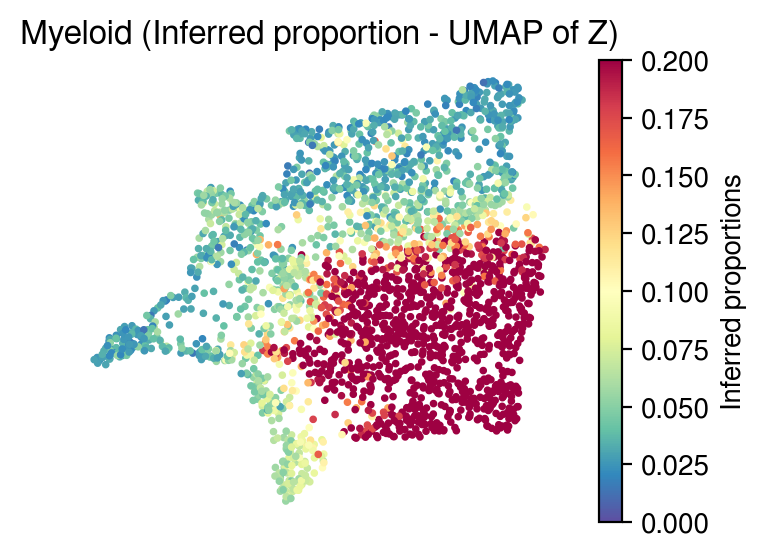

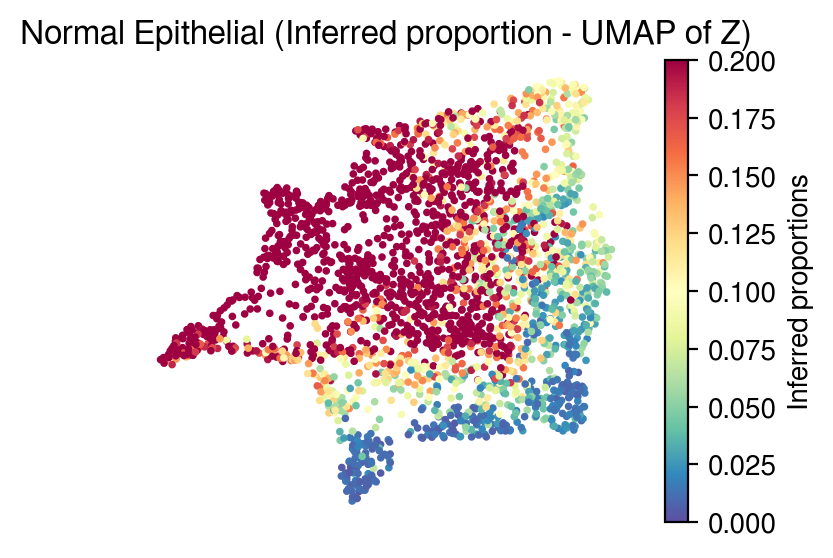

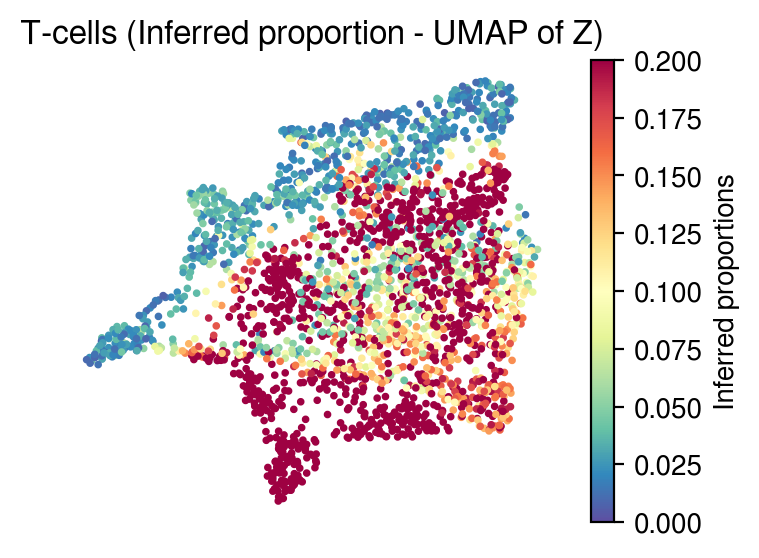

In [27]:
plot_utils.pl_spatial_inf_feature(adata,
                                  feature='qz_m',
                                  # To display for specific cell types:
                                  # factor = 'Cancer Epithelial', or factor = ['Cancer Epithelial, 'T-cells]
                                  spot_size=0.2,
                                  vmax=0.2)


##### Inferred cell-type specific expressions for each spot

In [28]:
pred_exprs = sf_model.model_ct_exp(model,
                                   adata,
                                   visium_args,
                                   poe=False,
                                   device=device)


The inferred predictions for each cell type is a `S x G'` matrix:

In [29]:
pred_exprs['CAFs'].shape

(2551, 2000)

E.g. Plot spot-level expression of `CD69` from *T-cells*:

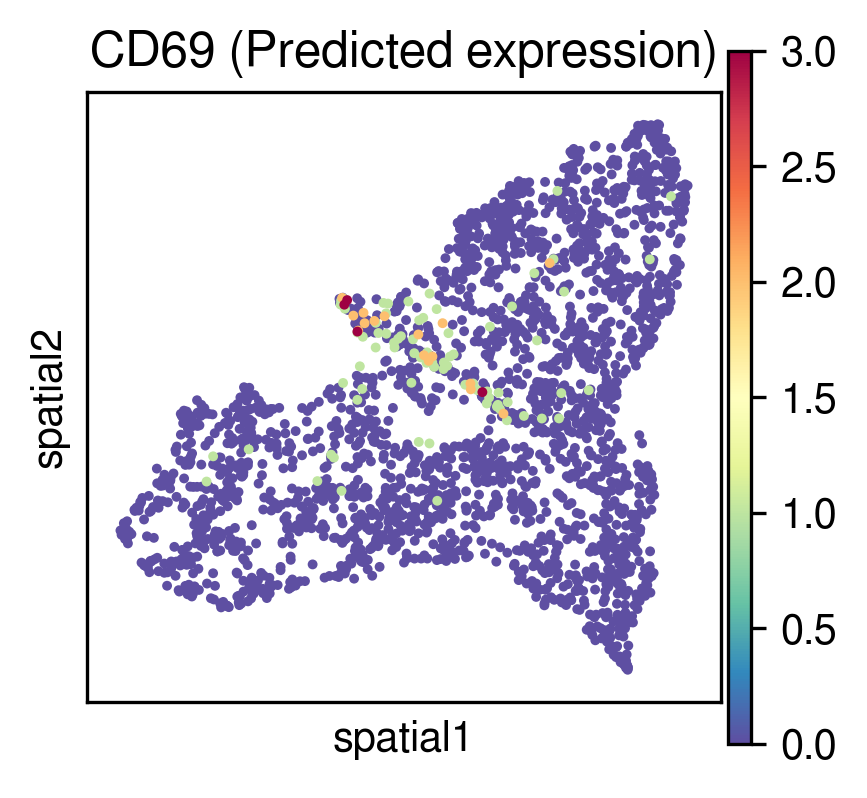

In [30]:
plot_utils.pl_spatial_inf_gene(adata,
                               factor='T-cells',
                               feature='CD69',
                               spot_size=0.2)


## Save model & inferred parameters

In [31]:
# Specify output directory
outdir = './results/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

# save the model
torch.save(model.state_dict(), os.path.join(outdir, 'starfysh_model.pt'))

# save `adata` object with inferred parameters
adata.write(os.path.join(outdir, 'st.h5ad'))

---